# Compare swr detection with mua detection

The idea is that units should increase their firing during HPC ripples. Being so, ripples without increased unit firing might be false positives. 

In [11]:
import glob
import pandas as pd
import os
import pickle 
import numpy as np
import math 
from matplotlib import pyplot as plt

import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import itertools
from ripple_detection.core import get_multiunit_population_firing_rate

from scipy import stats
from ripple_detection.core import gaussian_smooth, get_envelope

from neurodsp.filt import filter_signal


## Import mua data

In [2]:
df_mua = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\multiunit_data\post_processed\mua_df.csv')
df_mua

,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group
0,0,64.0895,64.3285,64.2555,0.239,LEM3116_S20180715121821,track,control
1,1,69.6875,69.8525,69.7725,0.165,LEM3116_S20180715121821,track,control
2,2,75.6615,75.7805,75.7065,0.119,LEM3116_S20180715121821,track,control
3,3,76.6735,76.8635,76.7755,0.190,LEM3116_S20180715121821,track,control
4,4,82.6235,82.7045,82.6595,0.081,LEM3116_S20180715121821,track,control
...,...,...,...,...,...,...,...,...
52908,52908,1474.8415,1475.0365,1474.9495,0.195,RH16_S20161207130000,track,pae
52909,52909,1517.8405,1517.9865,1517.9345,0.146,RH16_S20161207130000,track,pae
52910,52910,1517.9935,1518.2105,1518.1185,0.217,RH16_S20161207130000,track,pae
52911,52911,1532.9235,1532.9785,1532.9515,0.055,RH16_S20161207130000,track,pae


## load raw swr

In [3]:
save_path = "F:/Projects/PAE_PlaceCell/analysis/swr_data/"
sessions = glob.glob(save_path + '*.pkl')
ripple_map = []
filtered_map = []
phase_map = []
amp_map = []

freq_map = []

df_swr=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        ripple_times = pickle.load(f)
        ripple_maps = pickle.load(f)
    ripple_map.append(ripple_maps["ripple_map"])
    filtered_map.append(ripple_maps['filtered_map'])
    phase_map.append(ripple_maps['phase_map'])
    amp_map.append(ripple_maps['amp_map'])
    freq_map.append(ripple_maps['freq_map'])

    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    ripple_times['session'] = os.path.splitext(base)[0]
    df_swr = df_swr.append(ripple_times,ignore_index=True)

ripple_map = np.vstack(ripple_map)     
filtered_map = np.vstack(filtered_map)     
phase_map = np.vstack(phase_map)     
amp_map = np.vstack(amp_map)     
freq_map = np.vstack(freq_map) 

# make maps dict 
ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}
df_swr

,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,0,43.1920,43.5208,0.3288,0.996477,43.4592,6,31.291268,173.719424,0.006667,LEM3116_S20180715121821
1,1,45.0664,45.2520,0.1856,0.992112,45.1920,6,9.181491,136.852540,0.000000,LEM3116_S20180715121821
2,2,45.3264,46.3664,1.0400,0.995808,45.5488,7,8.901772,130.036443,0.000000,LEM3116_S20180715121821
3,3,46.3984,46.7056,0.3072,0.989954,46.5992,3,8.671494,175.020480,0.000000,LEM3116_S20180715121821
4,4,46.7280,46.8488,0.1208,0.996390,46.8000,3,6.160733,193.076538,0.006667,LEM3116_S20180715121821
...,...,...,...,...,...,...,...,...,...,...,...
90980,23,1221.2152,1221.3648,0.1496,0.119075,1221.2400,4,5.643901,164.414771,0.006667,RH16_S20161207130000
90981,24,1261.5728,1261.6360,0.0632,0.110154,1261.6056,4,6.129085,156.482260,0.026667,RH16_S20161207130000
90982,25,1274.4360,1274.5720,0.1360,0.233757,1274.4728,0,3.197711,108.029895,0.000000,RH16_S20161207130000
90983,26,1297.3568,1297.4872,0.1304,0.110988,1297.4168,3,51.975368,155.915173,0.000000,RH16_S20161207130000


### do some slight processing to remove some obvious false positives

Below, I keep ripple that are less than 1 second

In [8]:
# remove less than a second from swr
idx = df_swr.ripple_duration < 1
for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
df_swr = df_swr[idx]

# remove less than a second from mua
df_mua = df_mua[df_mua.ripple_duration < 1]


display(df_swr)
display(df_mua)

,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,0,43.1920,43.5208,0.3288,0.996477,43.4592,6,31.291268,173.719424,0.006667,LEM3116_S20180715121821
1,1,45.0664,45.2520,0.1856,0.992112,45.1920,6,9.181491,136.852540,0.000000,LEM3116_S20180715121821
3,3,46.3984,46.7056,0.3072,0.989954,46.5992,3,8.671494,175.020480,0.000000,LEM3116_S20180715121821
4,4,46.7280,46.8488,0.1208,0.996390,46.8000,3,6.160733,193.076538,0.006667,LEM3116_S20180715121821
5,5,53.1456,53.8504,0.7048,0.997383,53.2928,4,61.826521,141.171062,0.000000,LEM3116_S20180715121821
...,...,...,...,...,...,...,...,...,...,...,...
90980,23,1221.2152,1221.3648,0.1496,0.119075,1221.2400,4,5.643901,164.414771,0.006667,RH16_S20161207130000
90981,24,1261.5728,1261.6360,0.0632,0.110154,1261.6056,4,6.129085,156.482260,0.026667,RH16_S20161207130000
90982,25,1274.4360,1274.5720,0.1360,0.233757,1274.4728,0,3.197711,108.029895,0.000000,RH16_S20161207130000
90983,26,1297.3568,1297.4872,0.1304,0.110988,1297.4168,3,51.975368,155.915173,0.000000,RH16_S20161207130000


,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group
0,0,64.0895,64.3285,64.2555,0.239,LEM3116_S20180715121821,track,control
1,1,69.6875,69.8525,69.7725,0.165,LEM3116_S20180715121821,track,control
2,2,75.6615,75.7805,75.7065,0.119,LEM3116_S20180715121821,track,control
3,3,76.6735,76.8635,76.7755,0.190,LEM3116_S20180715121821,track,control
4,4,82.6235,82.7045,82.6595,0.081,LEM3116_S20180715121821,track,control
...,...,...,...,...,...,...,...,...
52908,52908,1474.8415,1475.0365,1474.9495,0.195,RH16_S20161207130000,track,pae
52909,52909,1517.8405,1517.9865,1517.9345,0.146,RH16_S20161207130000,track,pae
52910,52910,1517.9935,1518.2105,1518.1185,0.217,RH16_S20161207130000,track,pae
52911,52911,1532.9235,1532.9785,1532.9515,0.055,RH16_S20161207130000,track,pae


In [9]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session.iloc[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

#### Pull in lfp and mua to plot example

In [12]:
def plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,session,lims=20,rip_n=0):
    # look at current session only
    df = df[(df.session == session)]
    
    # find time window around ripple
    lower_lim = df.peak_time.iloc[rip_n] - lims
    upper_lim = df.peak_time.iloc[rip_n] + lims
    
    # locate channel that maximized ripple power
    peak_ch = df.peak_channel.iloc[rip_n]
    
    # restrict to just that time window
    temp_df = df[(df.start_time >= lower_lim) & (df.end_time <= upper_lim)]
    
    # find index for time window for lfp
    lfp_idx = (ts_lfp >= lower_lim) & (ts_lfp <= upper_lim)
    
    # zscore lfp for plotting
    zscore_lfp = stats.zscore(lfp[lfp_idx,peak_ch],axis=0)
    
    # plot lfp trace
    ax.plot(ts_lfp[lfp_idx],zscore_lfp + 5,color='#0b032a',label='raw lfp')  
    
    # bandpass filter lfp trace to ripple range and zscore for plotting
    signal = stats.zscore(filter_signal(lfp[lfp_idx,peak_ch],1250,'bandpass',(80,250),remove_edges=False),axis=0)    
    
    # plot filtered signal
    ax.plot(ts_lfp[lfp_idx],signal,color='#621940',alpha=.5,label='filtered lfp') 
    
    # get envelope
    smooth_envelope = gaussian_smooth(get_envelope(signal),0.004,1250)q`11
    ax.plot(ts_lfp[lfp_idx],smooth_envelope,color='#843b62',label='envelope') 
    
    # find index for time window for mua
    mua_idx = (ts_mua >= lower_lim) & (ts_mua <= upper_lim)
    
    # plot zscored mua
    ax.plot(ts_mua[mua_idx],stats.zscore(firing_rate[mua_idx],axis=0)-10,color='#ED553B',label='mua')

    # plot spike raster within window
    for i,s in enumerate(spike_times):
        s = s[(s >= lower_lim) & (s <= upper_lim)]
        ax.plot(s,np.zeros(len(s))-15-i,'|',color='#0b032a')

    # plot swr times within window
    for ripple in temp_df.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#843b62', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#843b62', zorder=1000)

    # plot mua times within window
    temp_df_mua = df_mua[(df_mua.session == session) & (df_mua.start_time >= lower_lim) & (df_mua.end_time <= upper_lim)]
    for ripple in temp_df_mua.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#ED553B', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#ED553B', zorder=1000)
        
    ax.legend(loc='upper right')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('time (sec)')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

### load data to plot example

In [13]:
session = np.where(df_swr.session=='LEM3216_S20190805141510')[0][0]
# session = np.where(df_swr.session=='LS19_S20170622141707')[0][0]

lfp,ts_lfp = get_lfp(df_swr,session)

# load spikes
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
spike_times = get_spikes(data_path+df_swr.session.iloc[session]+'.mat')

# bin spikes into single vector
st = list(itertools.chain.from_iterable(spike_times))
dt = 0.001
multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
# timestamps for binned spikes
ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

### plot example

* Shaded purple are detected ripple events

* Shaded orange are detected mua events

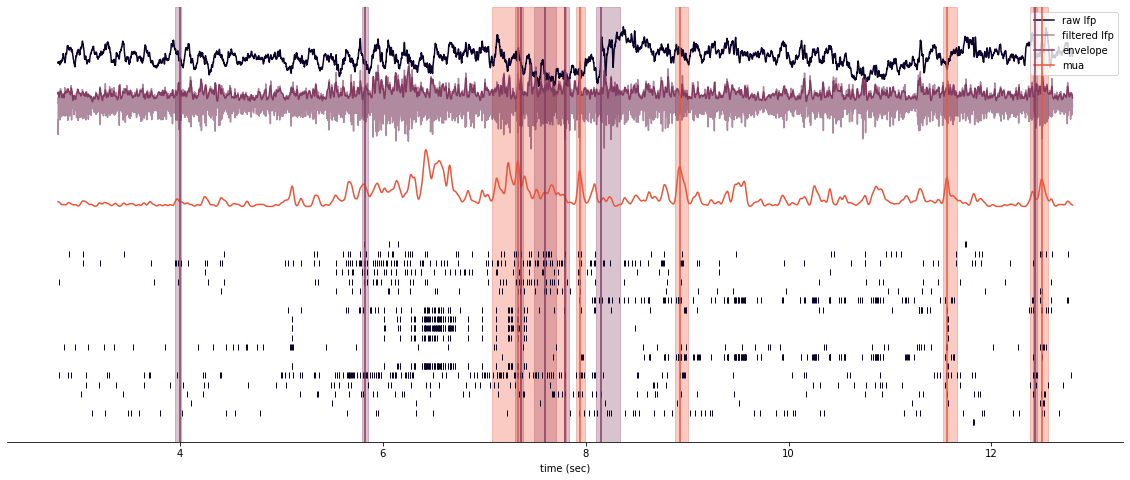

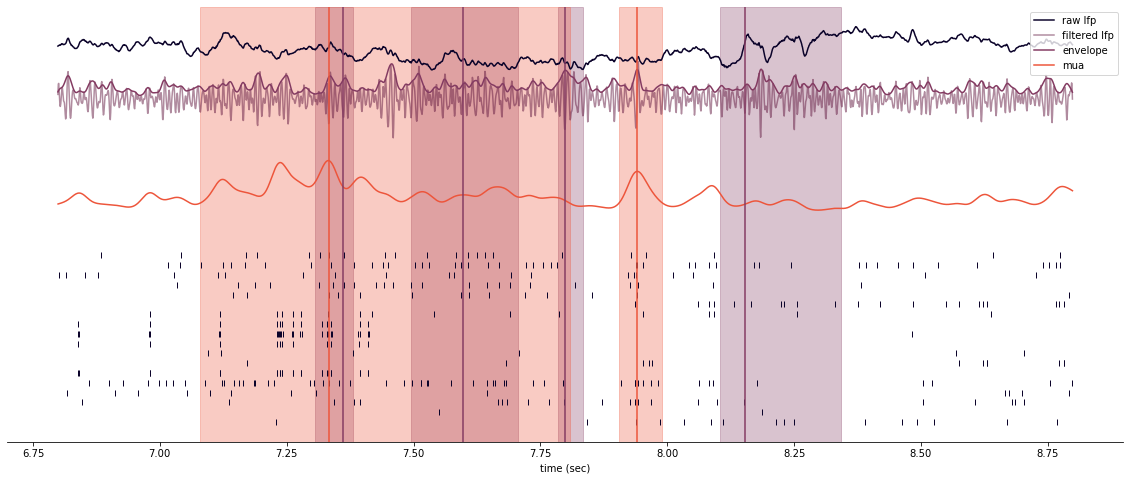

In [26]:
rip_n = 5
fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### check to find detected ripples overlap with of mua events

In [15]:
ripple_map_temp = []
filtered_map_temp = []
phase_map_temp = []
amp_map_temp = []
freq_map_temp = []

df=pd.DataFrame()

from IPython.display import clear_output
i=1

condition = []
for event in df_mua.itertuples():
    clear_output(wait=True)
    
    condition.append((df_swr.session == event.session) & (df_swr.peak_time >= event.start_time) & (df_swr.end_time <= event.end_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.start_time) & (df_swr.end_time >= event.start_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.end_time) & (df_swr.end_time >= event.end_time))
    idx = condition[0] | condition[1] | condition[2]
    condition = [] 
        
    ripple_map_temp.append(ripple_maps["ripple_map"][idx])
    filtered_map_temp.append(ripple_maps["filtered_map"][idx])
    phase_map_temp.append(ripple_maps["phase_map"][idx])
    amp_map_temp.append(ripple_maps["amp_map"][idx])
    freq_map_temp.append(ripple_maps["freq_map"][idx])
    
    event_times = df_swr[idx]
    df = df.append(event_times,ignore_index=True)
    
    i+=1
    print("Current progress:",np.round(i/len(df_mua)*100,2),"%")
    
ripple_map = np.vstack(ripple_map_temp)     
filtered_map = np.vstack(filtered_map_temp)     
phase_map = np.vstack(phase_map_temp)     
amp_map = np.vstack(amp_map_temp)     
freq_map = np.vstack(freq_map_temp)  

ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}

df 

Current progress: 100.0 %


,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,22,211.2472,211.3272,0.0800,0.990871,211.2960,3,5.566472,213.605249,0.000000,LEM3116_S20180715121821
1,60,517.9192,518.3112,0.3920,0.995188,518.0872,7,29.168512,203.155556,0.000000,LEM3116_S20180715121821
2,72,607.9384,608.3264,0.3880,0.990928,607.9640,3,7.932019,103.616382,0.000000,LEM3116_S20180715121821
3,80,675.9856,676.1392,0.1536,0.994272,676.0744,7,5.077734,173.913383,0.000000,LEM3116_S20180715121821
4,100,933.2264,933.4240,0.1976,0.992893,933.2784,7,27.285162,119.721685,0.000000,LEM3116_S20180715121821
...,...,...,...,...,...,...,...,...,...,...,...
17708,25,255.4504,255.5992,0.1488,0.314032,255.5336,7,8.094016,105.746020,0.000000,RH16_S20161126145021
17709,22,149.3840,149.5056,0.1216,0.133732,149.4368,6,12.060743,186.017137,0.000000,RH16_S20161126150318
17710,32,233.4192,233.5760,0.1568,0.260312,233.4960,7,8.145433,110.793201,0.000000,RH16_S20161126150318
17711,36,270.2880,270.4104,0.1224,0.065024,270.3288,0,4.390508,174.380797,0.000000,RH16_S20161126150318


### remove duplicates

In [22]:
idx = (~df.start_time.duplicated(keep='first')) & (~df.peak_freq.duplicated(keep='first'))

df = df[idx]
for key in ripple_maps.keys():
    ripple_maps[key] = ripple_maps[key][idx]
df

,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,22,211.2472,211.3272,0.0800,0.990871,211.2960,3,5.566472,213.605249,0.000000,LEM3116_S20180715121821
1,60,517.9192,518.3112,0.3920,0.995188,518.0872,7,29.168512,203.155556,0.000000,LEM3116_S20180715121821
2,72,607.9384,608.3264,0.3880,0.990928,607.9640,3,7.932019,103.616382,0.000000,LEM3116_S20180715121821
3,80,675.9856,676.1392,0.1536,0.994272,676.0744,7,5.077734,173.913383,0.000000,LEM3116_S20180715121821
4,100,933.2264,933.4240,0.1976,0.992893,933.2784,7,27.285162,119.721685,0.000000,LEM3116_S20180715121821
...,...,...,...,...,...,...,...,...,...,...,...
17708,25,255.4504,255.5992,0.1488,0.314032,255.5336,7,8.094016,105.746020,0.000000,RH16_S20161126145021
17709,22,149.3840,149.5056,0.1216,0.133732,149.4368,6,12.060743,186.017137,0.000000,RH16_S20161126150318
17710,32,233.4192,233.5760,0.1568,0.260312,233.4960,7,8.145433,110.793201,0.000000,RH16_S20161126150318
17711,36,270.2880,270.4104,0.1224,0.065024,270.3288,0,4.390508,174.380797,0.000000,RH16_S20161126150318


### add epoch data to dataframe

In [ ]:
def add_epoch_type(df,data_path):
    dicts = {}
    for session in df.session:
        f = h5py.File(data_path+session+'.mat','r')
        ex_ep = []
        for i in range(f['events'].shape[0]):
            ex_ep.append(f['events'][i])
        dicts[session] = ex_ep

    ep_type = ['pedestal_1','track','pedestal_2','cylinder_1','pedestal_3','cylinder_2','pedestal_4']
    df['ep_type'] = np.ones_like(df.session)
    # session_df=pd.DataFrame()
    for session in np.unique(df.session):
        # stack epoch times
        b = np.hstack(dicts[session])

        # add 0 to start to indicate the start of the recording session
        b = np.insert(b,0,0)

        # add the ts of the last ripple of the session to indicate end of session
        b = list(b)
        last_rip = max(df.end_time[df.session == session])
        if b[-1] < last_rip:
            b.append(last_rip)

        # loop through each epoch and label each ripple
        for ep in range(len(b)-1):
            idx = (df.session == session) & (df.peak_time >= b[ep]) & (df.peak_time <= b[ep+1])
            df['ep_type'][idx] = ep_type[ep]

    return df

df = add_epoch_type(df,data_path)


### add group affiliation to dataframe

In [ ]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'pae'
    return df
    
df = add_group_affiliation(df)    
df

### get ripple rate

Here, I am looking at how many ripples occured per second out of the valid time epochs where running speed was less than 4cm/sec

In [138]:
def get_ripple_rate(df,session):
    # get_ripple_rate: returns ripple rate in hz
    
    # load position data to get valid session duration
    pos_df = load_position(data_path+df.session.iloc[i]+'.mat') 
    # find time that ripples can occur (speeds < 4cm/sec)
    valid_time = sum(pos_df.speed < 4) * (pos_df.ts.iloc[1] - pos_df.ts.iloc[0]) 
    # divide the number of ripples by the amount of valid time in seconds to get ripples/sec
    return sum(df.session == session) / valid_time

# loop though each session to get ripples/sec
ripple_rate = [get_ripple_rate(df,session) for session in pd.unique(df.session)]

# make new dataframe where each row is a session
df_ripple_rate = pd.DataFrame()
df_ripple_rate["ripple_rate"] = ripple_rate

df_ripple_rate["session"] = pd.unique(df.session)

df_ripple_rate = add_group_affiliation(df_ripple_rate)

display(df_ripple_rate)

<ipython-input-128-caf292585f69>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-128-caf292585f69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


,ripple_rate,session,group
0,0.010138,LEM3116_S20180715121821,control
1,0.035945,LEM3116_S20180715160836,control
2,0.006452,LEM3116_S20180716115155,control
3,0.028571,LEM3116_S20180716174306,control
4,0.403685,LEM3116_S20180717110938,control
...,...,...,...
183,0.000922,RH16_S20161021165052,pae
184,0.004608,RH16_S20161030145324,pae
185,0.000922,RH16_S20161126145021,pae
186,0.002765,RH16_S20161126150318,pae


### save new df and maps

In [137]:
if not os.path.exists(save_path+'post_processed'):
    os.mkdir(save_path+'post_processed')

df.to_csv(save_path+'post_processed/swr_df.csv')
df_ripple_rate.to_csv(save_path+'post_processed/df_ripple_rate.csv')

# save file
with open(save_path+'post_processed/swr_df_maps.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(ripple_maps, f)

### plot example with new df where ripples must overlap mua

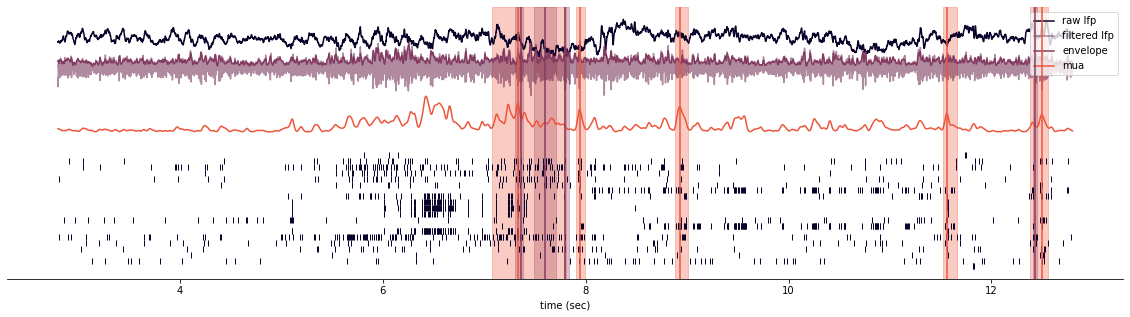

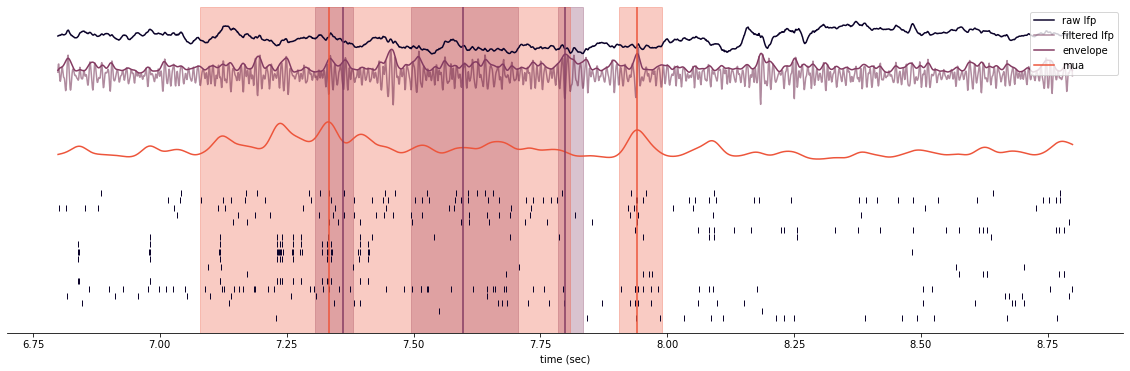

In [52]:
rip_n = 2
fig, ax = plt.subplots(1,1,figsize=(20, 5))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### make sure the overlap between ripple and mua is substantial

In [ ]:
# def get_mua_fr(session,dt = 0.001):
#     # load spikes
#     data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
#     spike_times = get_spikes(data_path+session+'.mat')
#     # bin spikes into single vector
#     st = list(itertools.chain.from_iterable(spike_times))
#     multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
#     # timestamps for binned spikes
#     ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
#     return ts_mua,get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

# def get_percent_overlap(df):
#     above_mean = []
#     # loop through each session
#     for session in pd.unique(df.session):
#         # pull out individual session
#         temp_df = df[df.session == session]
#         # get z scored mua firing rate
#         ts_mua, fr = get_mua_fr(session)
#         zscored_fr = stats.zscore(fr,axis=0)
#         # loop through each ripple event
#         for event in temp_df.itertuples():
#             # pull out mua firing rate during ripple
#             mua_values = zscored_fr[(ts_mua >= event.start_time) & (ts_mua <= event.end_time)]
#             # calculate the proportion where mua values are above the mean and save
#             above_mean.append(sum(mua_values > 0) / len(mua_values))
#     return above_mean

# above_mean = get_percent_overlap(df)
# df['ripple_mua_overlap'] = above_mean

# plt.figure(figsize=(20,4))
# plt.plot(above_mean)

# plt.figure(figsize=(4,4))
# plt.hist(above_mean,100)
# plt.show()


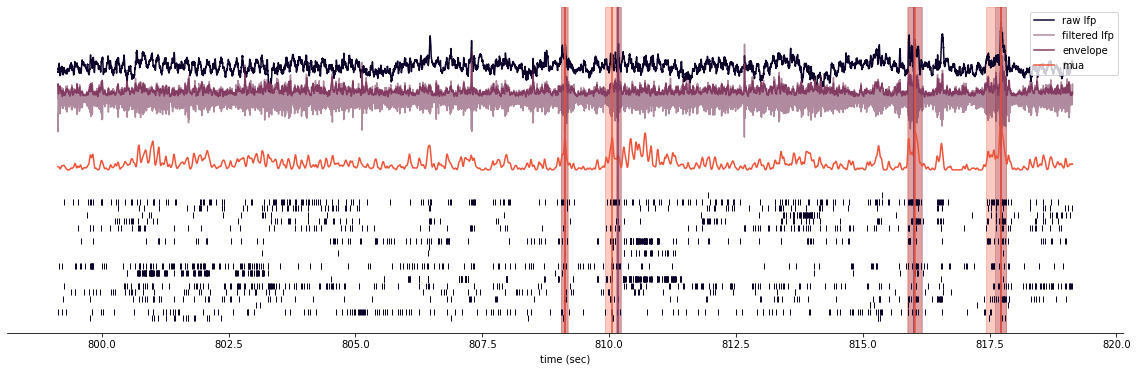

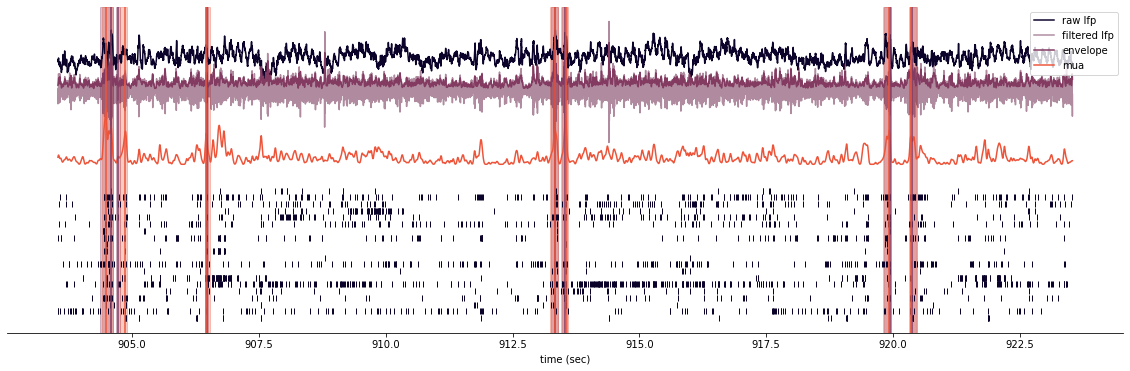

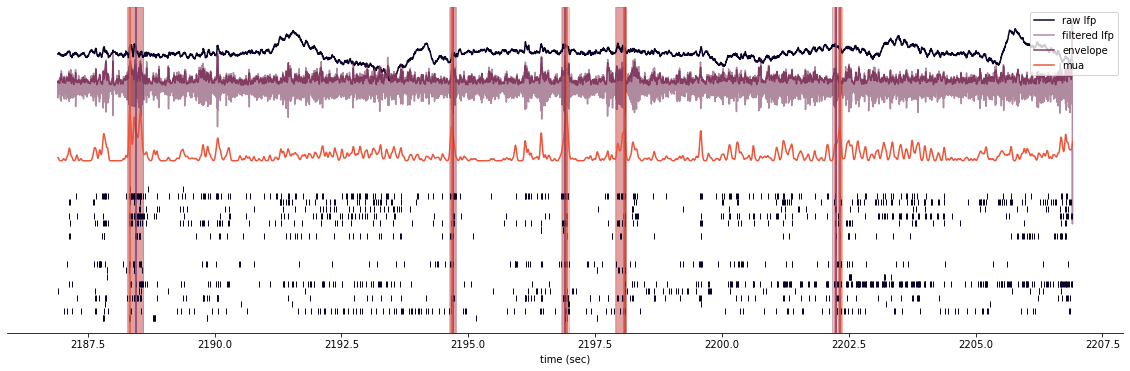

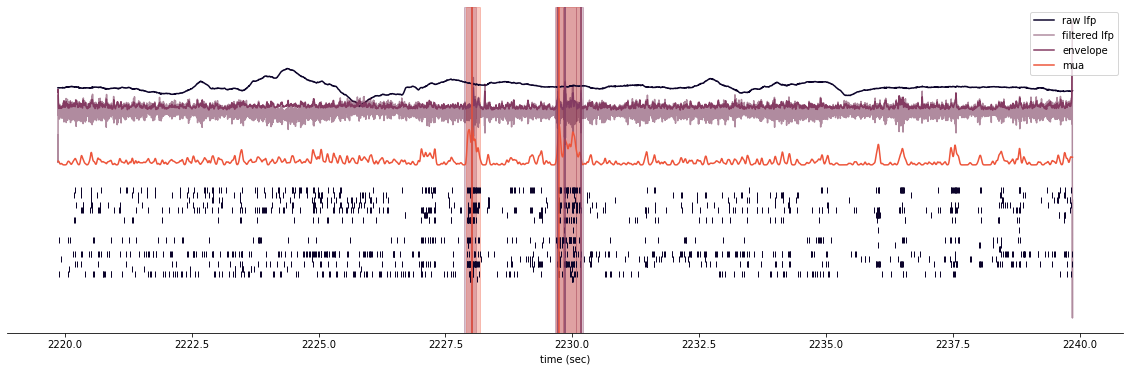

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=92)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=107)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=294)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=307)

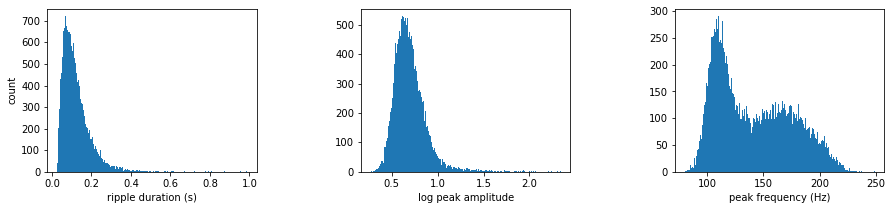

In [29]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

axs[0].hist(df.ripple_duration,200)
axs[0].set_ylabel('count')
axs[0].set_xlabel('ripple duration (s)')

axs[1].hist(np.log10(df.peak_amplitude),200)
axs[1].set_xlabel('log peak amplitude')

axs[2].hist(df.peak_freq,200)
axs[2].set_xlabel('peak frequency (Hz)')

plt.show()

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['ripple_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['freq_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['filtered_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['amp_map'][idx].T)
    axs[i].set_title(s)